#### Create parent folder for custom model training and child folders to store data

In [4]:

import shutil
shutil.unpack_archive("/Users/syedfaizan/Downloads/Datasets (1)/Capstone 1/Part 1/Images.zip")

In [5]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

### Prepare the dataset for model training

In [10]:
####Step 2: Load and preprocess the data

# Load the labels from labels.csv
labels_df = pd.read_csv('/Users/syedfaizan/Downloads/Datasets (1)/Capstone 1/Part 1/labels.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")

# Use iloc to pick the first 1000 labels
labels_df = labels_df.iloc[:1000]

# Load the corresponding images
images_dir = '/Users/syedfaizan/Downloads/Datasets (1)/Capstone 1/Part 1/Images'
images = []
for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)
    else:
        print(f"Error loading image: {img_path}")

# Check if images are loaded
if len(images) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")

1000 images loaded successfully.


In [20]:
labels

array([ 8,  3,  3,  0,  3,  2,  2,  3,  3,  3,  3,  5,  3,  3,  2,  3,  0,
        3,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  8,  0, 10,
        5,  3,  5,  3,  3,  3,  0,  3,  3,  3,  3,  3,  2,  2,  3,  5,  3,
        3,  3,  3,  5,  8,  3,  8,  3,  3,  8,  3,  3,  3,  3,  9,  9,  3,
        8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  8,  3,
        3,  9,  3,  3,  8,  3,  3,  8,  8,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  5,  3, 10,  3,  3,  2,  3,  3,  3, 10,  8,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  5,  7,  3,  3,  5,  3,  8,  3,  3,
        8,  3,  3,  3,  3,  3,  5,  3,  8,  8, 10,  8,  8,  3,  8,  3,  3,
        3,  5,  3,  5,  8,  3,  5,  8,  8,  3,  3, 10,  0,  5,  3,  8,  3,
        3,  8,  3,  8,  3,  3,  5,  3,  3,  3,  8,  8,  3,  8, 10,  3,  3,
        8,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  0,  3,  3,  3,
        3,  3,  3,  3,  3

In [8]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

# Address data quality issues arising from the discrepancy between labels and actual image filenames
# Sorting the image filenames
labels_df = labels_df.sort_values('image_id')


Distribution of vehicle types:
class
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: count, dtype: int64


In [11]:
if len(images) > 0:
    processed_images = [cv2.resize(img, (224, 224)) for img in images]  # Adjust dimensions as needed
    processed_images = np.array(processed_images)
    print("Images resized successfully.")

Images resized successfully.


In [12]:
labels = labels_df['class'].to_numpy()
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# Convert labels to one-hot encoding
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])

In [13]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images, labels, bounding_boxes, test_size=0.2, random_state=42)

#### Create an CNN architecture for object detection

In [14]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, name='bounding_box')(x)

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model

input_shape = processed_images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)


model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=100, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - bounding_box_loss: 683045.3750 - bounding_box_mae: 346.9646 - loss: 683290.5000 - vehicle_class_accuracy: 0.5125 - vehicle_class_loss: 245.0359 - val_bounding_box_loss: 26443.0566 - val_bounding_box_mae: 126.9459 - val_loss: 26128.3359 - val_vehicle_class_accuracy: 0.6850 - val_vehicle_class_loss: 97.8276
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - bounding_box_loss: 24436.2383 - bounding_box_mae: 120.4283 - loss: 24547.3301 - vehicle_class_accuracy: 0.6612 - vehicle_class_loss: 111.0944 - val_bounding_box_loss: 22199.6270 - val_bounding_box_mae: 116.4450 - val_loss: 22167.7070 - val_vehicle_class_accuracy: 0.5750 - val_vehicle_class_loss: 73.5075
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - bounding_box_loss: 20910.2344 - bounding_box_mae: 110.5712 - loss: 20988.3281 - vehicle_class_accuracy: 0.5675 - vehicle_class_loss: 78.0959 - val_bounding_box_loss: 23934.6543 - val_bounding_box_mae: 121.7623 - val_loss

#### Evaluate the model and check the test results

In [15]:
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

7/7 - 1s - 92ms/step - bounding_box_loss: 25666.1777 - bounding_box_mae: 118.4763 - loss: 25952.7148 - vehicle_class_accuracy: 0.5900 - vehicle_class_loss: 2.6370

Test results: [25952.71484375, 2.637014389038086, 25666.177734375, 118.47634887695312, 0.5899999737739563]


#### Run inferences on the images 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


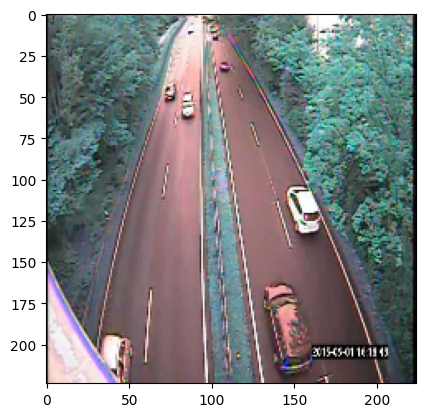

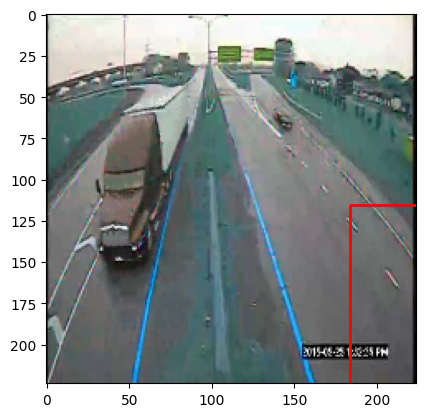

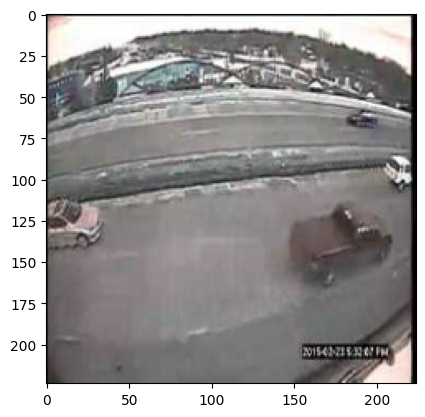

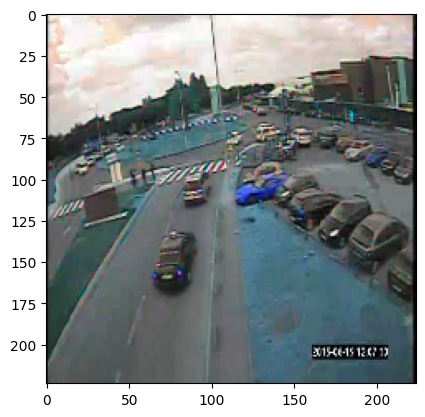

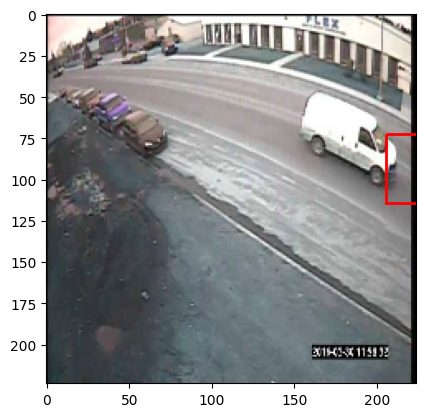

In [16]:
import matplotlib.pyplot as plt

# Choose a few sample images for inference
sample_images = X_test[:5]  # Adjust the number of sample images as needed

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1], 
                                     fill=False, edgecolor='r', linewidth=2))
    plt.show()